In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib
import openpyxl
from sklearn.svm import SVR
from xgboost import XGBRegressor
import scienceplots
import matplotlib.pyplot as plt


# 00 General + functions

In [3]:
# INPUT 1/4
model_input = 'Log_periods'
model_target = 'Ratio_median'
x_label = model_input
y_label = "Sa_RotD100/Sa_RotD50"
title = f"Ratio of {y_label} vs {x_label}"


# Plot input data
y_label=r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$"
x_label="Periods (s)"
title = ""
file_name = model_target
save_path = "figures_report/" # save in figures_report folder - None if you don't want to save

In [4]:
# Load the pickled DataFrame
df_dataset = pd.read_pickle(f'datasets/working_df.pkl')[[model_input, model_target]]

min_value = df_dataset[model_input].min()
max_value = df_dataset[model_input].max()

df_dataset

,Log_periods,Ratio_median
0,-2.000000,1.200727
1,-1.698970,1.199830
2,-1.657577,1.199338
3,-1.602060,1.198367
4,-1.537602,1.197620
...,...,...
100,0.903090,1.266621
101,0.929419,1.269646
102,0.954243,1.271049
103,0.977724,1.271696


In [5]:
# Define features and target
X = df_dataset[[model_input]]  # Features
y = df_dataset[model_target]    # Target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 0.1 Functions

In [6]:
def hyperparameter_selection(X_train, y_train, model, param_grid, model_name, model_target):
    """
    Performs hyperparameter tuning using GridSearchCV and saves the best model and cross-validation results.

    Args:
        X_train (pd.DataFrame or np.array): Training feature set.
        y_train (pd.Series or np.array): Training target values.
        model (sklearn.base.BaseEstimator): Machine learning model to be optimized.
        param_grid (dict): Dictionary containing hyperparameter grid for tuning.
        model_name (str): Name identifier for the model.
        model_target (str): Target variable for which the model is trained.

    Returns:
        None

    Saves:
        - The best trained model as a `.pkl` file in the `models/` directory.
        - The cross-validation results as an Excel file in the `models/` directory.
    """
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Cross-Validated MSE Score:", best_score)

    # Evaluate on the test set
    best_model = grid_search.best_estimator_

    # Save the model to a .pkl file
    joblib.dump(best_model, f'models/{model_name}_{model_target}.pkl')
    print(f"Model saved as {model_name}_{model_target}.pkl")

    # Extract cross-validation results
    cv_results = grid_search.cv_results_

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'hyperparameters': cv_results['params'],
        'mean MSE': cv_results['mean_test_score'],
        'std': cv_results['std_test_score']
    })

    # Save the DataFrame to an Excel file
    excel_filename = f'models/{model_name}_{model_target}_results.xlsx'
    results_df.to_excel(excel_filename, index=False)
    print(f"Cross-validation results saved to {excel_filename}")

In [7]:
def plot_actual_prediction(best_model):
    """
    Plots actual test data and the model's predictions.

    This function relies on global variables for the test data (`X_test`, `y_test`), 
    feature range (`min_value`, `max_value`), and plot labels (`x_label`, `y_label`, `title`).

    Args:
        best_model (sklearn.base.BaseEstimator): Trained machine learning model.

    Returns:
        None

    Displays:
        - A scatter plot of actual test data.
        - A red line representing model predictions over the feature range.

    Note:
        This function assumes that `X_test`, `y_test`, `min_value`, `max_value`, `x_label`, 
        `y_label`, and `title` are defined globally.
    """
    # Scatter plot for the actual data
    plt.scatter(X_test, y_test, label="Testing Data", color="blue", alpha=0.7)

    # Generate predictions across the range of Periods (min to max)
    X_line = np.linspace(min_value, max_value, 500).reshape(-1, 1)
    y_line_pred = best_model.predict(X_line)

    # Plot the line for predictions
    plt.plot(X_line, y_line_pred, label="Model Prediction", color="red", linewidth=2)

    # Add labels, legend, and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [8]:
def plot_hyperparameters_set(model_name, model_target):
    """
    Loads and visualizes hyperparameter tuning results from an Excel file.

    This function:
    - Reads the hyperparameter tuning results from an Excel file.
    - Sorts the hyperparameters by mean MSE in descending order.
    - Plots the mean MSE values for different hyperparameter sets.
    - Extracts and prints the best hyperparameter set.
    - Returns the top 10 hyperparameter sets.

    Args:
        model_name (str): Name identifier of the model.
        model_target (str): Target variable or model purpose.

    Returns:
        pd.DataFrame: A DataFrame containing the top 10 hyperparameter sets with:
            - 'hyperparameters': The hyperparameter settings.
            - 'mean MSE': The corresponding mean test MSE.
            - 'std': The standard deviation of the MSE scores.

    Displays:
        - A line plot of mean MSE values sorted in descending order.
        - Prints the best hyperparameter set.
    """
    # 1. Load the Excel file
    excel_filename = f'models/{model_name}_{model_target}_results.xlsx'
    results_df = pd.read_excel(excel_filename)

    # 2. Sort the hyperparameters based on the mean MSE in descending order
    sorted_results = results_df.sort_values(by='mean MSE', ascending=False)

    # Step 3: Plot descending the hyperparameters based on the mean MSE
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_results['mean MSE'].values)
    plt.title(f'Hyperparameters Sorted by Mean MSE for {model_name}')
    plt.xlabel('Hyperparameter Set Index')
    plt.ylabel('Negative Mean MSE')
    plt.show()

    # Step 4: Extract the top 10 hyperparameter sets
    top_10 = sorted_results.head(10)

    # Step 5: Print the best model
    print(f"The best hyperparameter's set is:\n {top_10['hyperparameters'].iloc[0]}")

    # Return the top 10 hyperparameter sets with mean test score
    return top_10[['hyperparameters', 'mean MSE', 'std']]

# 01 Random Forest

In [9]:
# INPUT 2/4
# Model
model_name = 'Random_Forest'

# INPUT 3/4
mode = 1

# modes
# 0: training the model
# 1: loading the model

In [10]:
# INPUT 4/4
if not mode:
    # Define the model
    rf = RandomForestRegressor(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
        'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
        'max_depth': [None, 10, 20, 30, 50],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    }

    hyperparameter_selection(X_train, y_train, rf, param_grid, model_name, model_target)

In [11]:
# Load the model from the .pkl file
best_model = joblib.load(f'models/{model_name}_{model_target}.pkl')

y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store performance metrics in a DataFrame
performance_df = pd.DataFrame({
    'Model': [model_name],
    'MSE': [mse],
    'R2 Score': [r2]
})

print("Test MSE:", mse)
print("Test R2 Score:", r2)

Test MSE: 4.387016960751021e-07
Test R2 Score: 0.9992444307761594


c:\Users\vhcal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


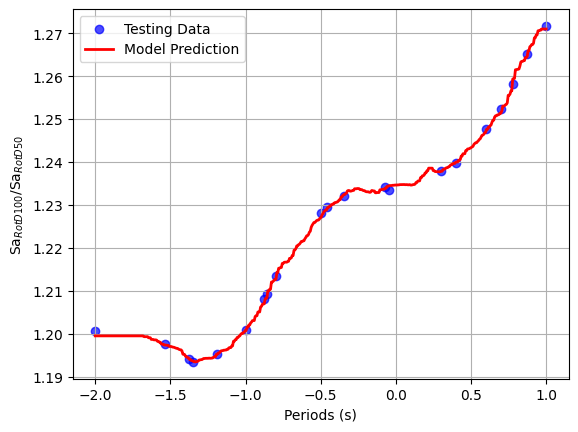

In [12]:
plot_actual_prediction(best_model)

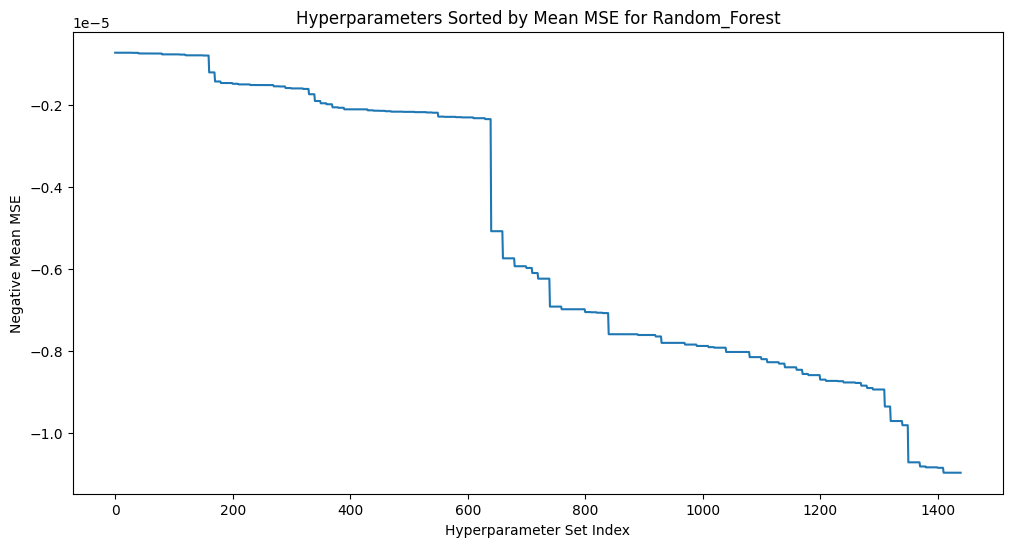

The best hyperparameter's set is:
 {'criterion': 'poisson', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [13]:
hyp_df = plot_hyperparameters_set(model_name, model_target)

In [14]:
# print(f"Top 10 Hyperparameter Sets Based on Mean negative MSE for {model_name}:")
hyp_df

,hyperparameters,mean MSE,std
1406,"{'criterion': 'poisson', 'max_depth': 50, 'max...",-7.217202e-07,3.867345e-07
1370,"{'criterion': 'poisson', 'max_depth': 50, 'max...",-7.217202e-07,3.867345e-07
1298,"{'criterion': 'poisson', 'max_depth': 30, 'max...",-7.217202e-07,3.867345e-07
1334,"{'criterion': 'poisson', 'max_depth': 30, 'max...",-7.217202e-07,3.867345e-07
1226,"{'criterion': 'poisson', 'max_depth': 20, 'max...",-7.217202e-07,3.867345e-07
1118,"{'criterion': 'poisson', 'max_depth': None, 'm...",-7.217202e-07,3.867345e-07
1262,"{'criterion': 'poisson', 'max_depth': 20, 'max...",-7.217202e-07,3.867345e-07
1082,"{'criterion': 'poisson', 'max_depth': None, 'm...",-7.217202e-07,3.867345e-07
974,"{'criterion': 'friedman_mse', 'max_depth': 30,...",-7.217202e-07,3.867345e-07
938,"{'criterion': 'friedman_mse', 'max_depth': 30,...",-7.217202e-07,3.867345e-07


# 02 SVM

In [15]:
# INPUT 2/4
# Model
model_name = 'SVM'

# INPUT 3/4
mode = 1

# modes
# 0: training the model
# 1: loading the model

In [16]:
# INPUT 4/4
if not mode:
    # Define the Supported Vector Machine model
    svr = SVR()

    # Define the parameter grid for RandomForestRegressor
    param_grid = {
        'kernel': ['rbf', 'sigmoid'],  # Different kernel types
        'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5, 0.01, 0.001],  # Margin of tolerance
        #'degree': [2, 3, 4, 5]  # Degree for polynomial kernel (only applicable for 'poly' kernel)
    }
    hyperparameter_selection(X_train, y_train, svr, param_grid, model_name, model_target)

In [17]:
# Load the model from the .pkl file
best_model = joblib.load(f'models/{model_name}_{model_target}.pkl')

y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store performance metrics in a DataFrame
performance_df = pd.concat([performance_df, 
pd.DataFrame({
    'Model': [model_name],
    'MSE': [mse],
    'R2 Score': [r2]
})]
, ignore_index=True)

print("Test MSE:", mse)
print("Test R2 Score:", r2)

Test MSE: 4.784639835157609e-06
Test R2 Score: 0.9917594879642592


c:\Users\vhcal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


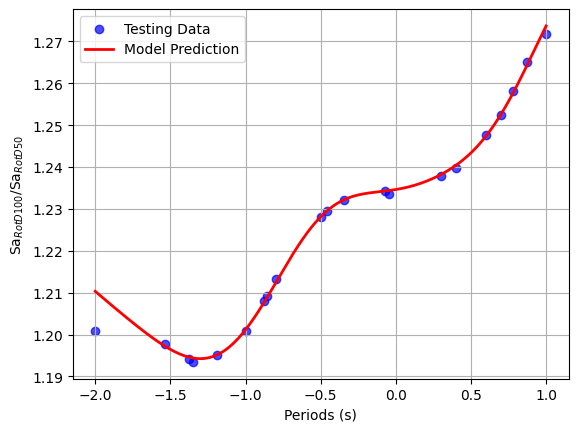

In [18]:
plot_actual_prediction(best_model)

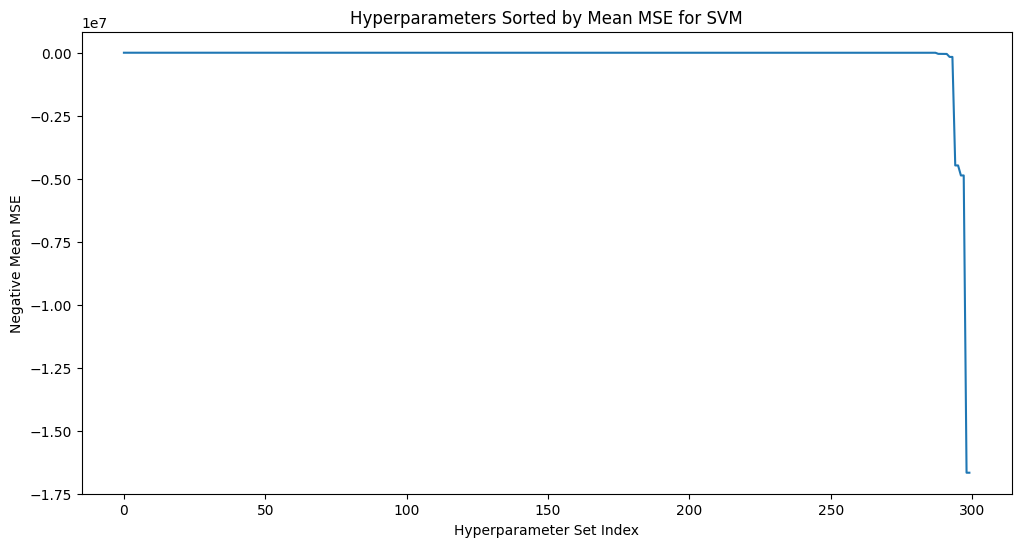

The best hyperparameter's set is:
 {'C': 1, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}


In [19]:
hyp_df = plot_hyperparameters_set(model_name, model_target)

In [20]:
# print(f"Top 10 Hyperparameter Sets Based on Mean negative MSE for {model_name}:")
hyp_df

,hyperparameters,mean MSE,std
108,"{'C': 1, 'epsilon': 0.001, 'gamma': 'scale', '...",-6.557460e-07,2.499458e-07
168,"{'C': 10, 'epsilon': 0.001, 'gamma': 'scale', ...",-6.816365e-07,2.681315e-07
178,"{'C': 10, 'epsilon': 0.001, 'gamma': 1, 'kerne...",-6.870795e-07,3.200068e-07
170,"{'C': 10, 'epsilon': 0.001, 'gamma': 'auto', '...",-6.870795e-07,3.200068e-07
230,"{'C': 100, 'epsilon': 0.001, 'gamma': 'auto', ...",-7.353732e-07,4.715691e-07
238,"{'C': 100, 'epsilon': 0.001, 'gamma': 1, 'kern...",-7.353732e-07,4.715691e-07
290,"{'C': 1000, 'epsilon': 0.001, 'gamma': 'auto',...",-7.432160e-07,5.001341e-07
298,"{'C': 1000, 'epsilon': 0.001, 'gamma': 1, 'ker...",-7.432160e-07,5.001341e-07
228,"{'C': 100, 'epsilon': 0.001, 'gamma': 'scale',...",-7.541276e-07,3.423904e-07
288,"{'C': 1000, 'epsilon': 0.001, 'gamma': 'scale'...",-7.699665e-07,2.653680e-07


# 03 XGBoost

In [21]:
# INPUT 2/4
# Model
model_name = 'XGBoost'

# INPUT 3/4
mode = 1

# modes
# 0: training the model
# 1: loading the model

In [22]:
# INPUT 4/4
if not mode:
    # Define the XGBoost Regressor
    xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

    # Define the parameter grid for XGBoost
    param_grid = {
        'n_estimators': [100, 200, 500, 1000],  # Number of boosting rounds (trees)
        'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage
        'max_depth': [3, 5, 10],  # Maximum depth of a tree
        'subsample': [0.8],  # Fraction of samples used per tree
        'gamma': [0, 1, 5],  # Minimum loss reduction required to split a node
        'reg_alpha': [0, 10],  # L1 regularization term
        'reg_lambda': [1, 10],  # L2 regularization term
    }

    # Pass the model and parameter grid to the hyperparameter selection function
    hyperparameter_selection(X_train, y_train, xgb_model, param_grid, model_name, model_target)

In [23]:
# Load the model from the .pkl file
best_model = joblib.load(f'models/{model_name}_{model_target}.pkl')

y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Store performance metrics in a DataFrame
performance_df = pd.concat([performance_df, 
pd.DataFrame({
    'Model': [model_name],
    'MSE': [mse],
    'R2 Score': [r2]
})]
, ignore_index=True)

print("Test MSE:", mse)
print("Test R2 Score:", r2)

Test MSE: 1.4256134750417185e-06
Test R2 Score: 0.9975446877081379


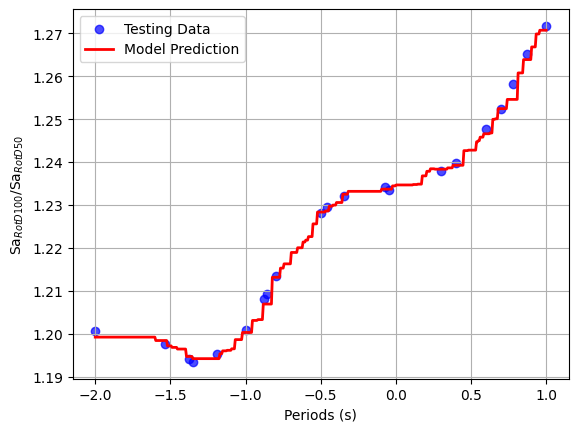

In [24]:
plot_actual_prediction(best_model)

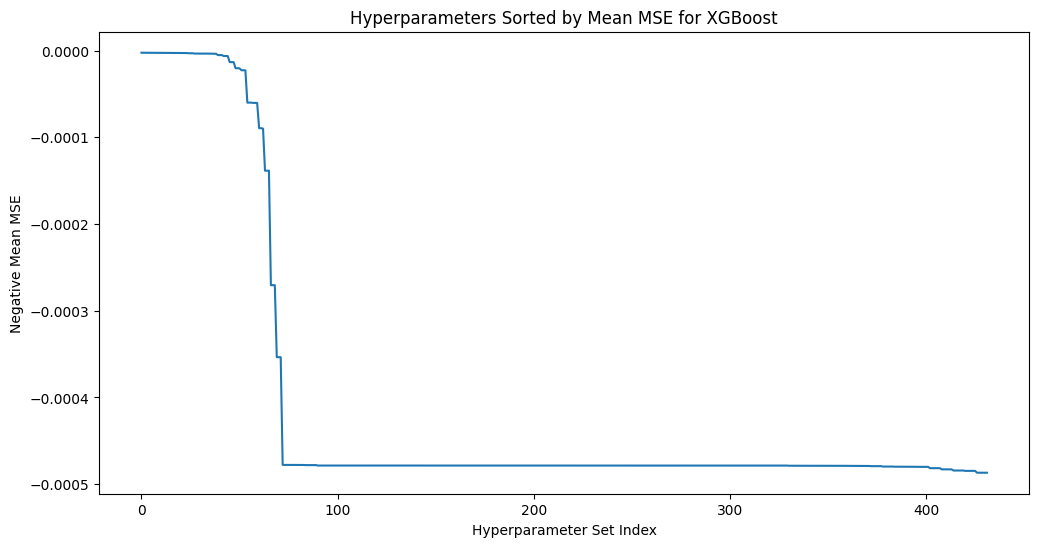

The best hyperparameter's set is:
 {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}


In [25]:
hyp_df = plot_hyperparameters_set(model_name, model_target)

In [26]:
# print(f"Top 10 Hyperparameter Sets Based on Mean negative MSE for {model_name}:")
hyp_df

,hyperparameters,mean MSE,std
104,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
96,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
100,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
136,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
108,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
112,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
132,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
120,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
128,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002
116,"{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...",-0.000003,0.000002


# Plots

In [27]:
# Load models from each three models from the .pkl file
best_model_rf = joblib.load(f'models/Random_Forest_{model_target}.pkl')
best_model_svm = joblib.load(f'models/SVM_{model_target}.pkl')
best_model_xgb = joblib.load(f'models/XGBoost_{model_target}.pkl')

# Convert from log10 to normal
min_value_lin = 10 ** min_value
max_value_lin = 10 ** max_value
X_test_lin = 10 ** X_test

In [28]:
def science_plot_multiple_models(
    best_model_rf, best_model_svm, best_model_xgb,
    x_label, y_label, title, save_path, file_name
):
    """
    Plots the actual testing data and model predictions from three models 
    (Random Forest, SVM, XGBoost) using the 'science' style.

    Parameters:
    - best_model_rf: The Random Forest model with a `.predict` method.
    - best_model_svm: The SVM model with a `.predict` method.
    - best_model_xgb: The XGBoost model with a `.predict` method.
    - x_label: Label for the x-axis (str), e.g., "Periods (s)".
    - y_label: Label for the y-axis (str), typically a LaTeX-formatted string, e.g., 
               r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$".
    - title: Title of the plot (str). Leave as an empty string for no title.
    - save_path: Optional (str). Directory path to save the plot. If None, the plot is not saved.
    - file_name: Optional (str). Name of the file to be saved (without extension).

    Example Usage:
    science_plot_multiple_models(
        best_model_rf=rf_model,
        best_model_svm=svm_model,
        best_model_xgb=xgb_model,
        x_label="Periods (s)",
        y_label=r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$",
        title="Model Comparison: Random Forest, SVM, XGBoost",
        save_path="figures_report",
        file_name="comparison_plot"
    )
    """
    with plt.style.context(['science']):
        fig, ax = plt.subplots()

        # Scatter plot for the actual test data
        ax.scatter(X_test_lin, y_test, label="Testing Data", color="blue", alpha=0.7)

        # Generate predictions across the range of values for each model
        X_line = np.linspace(min_value, max_value, 500).reshape(-1, 1)
        X_line_lin = 10 ** X_line

        y_line_pred_rf = best_model_rf.predict(X_line)
        y_line_pred_svm = best_model_svm.predict(X_line)
        y_line_pred_xgb = best_model_xgb.predict(X_line)

        # Plot the model prediction curves
        ax.plot(X_line_lin, y_line_pred_rf, label="Random Forest", color="red", linewidth=2, linestyle="--")
        ax.plot(X_line_lin, y_line_pred_svm, label="SVM", color="green", linewidth=2, linestyle="-.")
        ax.plot(X_line_lin, y_line_pred_xgb, label="XGBoost", color="orange", linewidth=2, linestyle=":")

        # Set the x-axis to a logarithmic scale
        ax.set_xscale("log")
        
        ax.set_xlabel(x_label, fontsize=10)  # Increased font size for x-axis label
        ax.set_ylabel(y_label, fontsize=15)  # Increased font size for y-axis label

        # Add labels, legend, and title
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
        ax.legend(loc="best")
        ax.autoscale(tight=True)

        # Save the plot if save_path is provided
        if save_path:
            # Ensure the save path ends with a slash and construct the file name
            save_path = save_path.rstrip("/") + "/"
            full_file_path = f"{save_path}{file_name}.pdf"
            fig.savefig(full_file_path, format="pdf", dpi=300)
            print(f"Plot saved as PDF at {full_file_path}")
            
        if save_path:
    # Ensure the save path ends with a slash and construct the file name
            save_path = save_path.rstrip("/") + "/"
            full_file_path = f"{save_path}{file_name}.png"
            fig.savefig(full_file_path, format="png", dpi=600)  # Set DPI to 600 for high quality
            print(f"Plot saved as PNG at {full_file_path}")

        # Show the plot
        plt.show()


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\vhcal\AppData\Local\Temp\ipykernel_14416\1006979393.py:5: SyntaxWarning: invalid escape sequence '\m'
  """


c:\Users\vhcal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\vhcal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


Plot saved as PDF at figures_report/Ratio_median.pdf
Plot saved as PNG at figures_report/Ratio_median.png


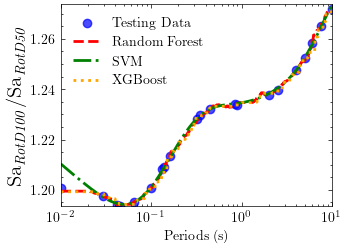

In [29]:
science_plot_multiple_models(
    best_model_rf=best_model_rf,
    best_model_svm=best_model_svm,
    best_model_xgb=best_model_xgb,
    x_label=x_label,
    y_label=y_label,
    title=title,
    save_path=save_path,
    file_name=file_name
)

In [30]:
# Sort the DataFrame by 'MSE'
sorted_performance_df = performance_df.sort_values(by='MSE')

# Print the sorted DataFrame
sorted_performance_df

,Model,MSE,R2 Score
0,Random_Forest,4.387017e-07,0.999244
2,XGBoost,1.425613e-06,0.997545
1,SVM,4.784640e-06,0.991759
